In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import re
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report

import abs_tag_lib as at

# Abstract classification via word2vec embedding

### Goal

The aim of this study is to understand whether a word2vec embedding coupled with a neural network for classification can achieve better performance than simpler embeddings like bag-of-words or tf-idf vectorizers. Our study is divided in two main parts,


- PART 1: We train a word2vec embedder using ~20,000 abstracts collected via the Nature metadata dataset, filtered by the keyword *field theory*.


- PART 2: We consider a restricted dataset, produced in a previous study (see the [link](https://github.com/carlosparaciari/abstract-classification-supervised)) where the abstract have labels from 9 possible classes, and we train different neural network architectures for classification.

### Methods

We use a dataset that we have extracted, analysed, and cleanded in a different stduy (see link above). The dataset is obtained via the Nature metadata API. From previous analysis, we know that ensemble learners and linear methods achieve an accuracy of around 73-77% on this dataset, with observations from 3 of the 9 classes being particulary difficult to correctly assign. The word embedding used in the previous study is a tf-idf vectorizer.

In the first part of the project, we train the gensim word2vec model to embed words commonly appearing in scientific papers, and particularly in papers concerning *quantum field theory*. We decide to train the embedder instead of using a pre-trained model since abstracts of papers published in scientific journals ofter contains lots of jargon.

The second stage of this project consists in training different architectures of neural networks for classifying the abstracts. Specifically, we first use a Convolutional Neural Network (CNN) searching for specific features involving a given number of words in the text. Later, we use a Recursive Neural Network (RNN) to obtian information from the whole abstract.

### Results

For what concerns the word2vec embedding we trained, we can only judge its performance by demanding similar words to a given set of words, that we consider meaningful for the task. While the model we trained is by no means general enough to be used in production, it seems to be sufficient for our pourposes. Indeed, almost all the word associations made by the model seem to be reasonable.

For example, the model suggests that the most similar words to "eth" are "eigenstate" and "thermalization", that indeed are the first two terms in the acronim. For "ads cft", the model associate "holography", that indded is a primary feature of the AdS-CFT correspondence.

We then train abstract classifiers using different Neural Network architectures, see below for a detailed description of the architectures. Interestingly, the two architectures used perform very differently, with the CNN achieving an accuracy ~ 81% (thus outperforming all previous methods used on this dataset), and the RNN obtaining an accuracy of ~ 74% (close to the one achived by Gradient Boosting in the previous study).

Furthermore, we find that the RNN requires an higher number of weights (equivalently, hidden nodes/layers) than the CNN, and the training takes considerably more time.

### Remarks

There are multiple aspects that could be interesting studying.

- For the word2vec embedding, we trained the model using CBOW (continuous bag-of-words), but an alternative could be Skip-Gram. In order to achive better embeddings, one should also probably use a much bigger corpus than the one used here.


- We could also try to use pre-trained embeddings, although these are (reasonably) trained on non-scientific texts, and therefore would struggle with the jargon used in scientific jounal abstracts. We could use the embedding as a baseline.


- The two NN architectures used here are quite simple, and it might be interesting to use more advanced one (e.g. Bidirectional Encoder Representations from Transformers, BERT)

### Sections

- Word2vec embedding using gensim

- Abstract classifiers using TensorFlow/Keras
    - Convolutional Neural Network
    - Recursive Neural Network
    
- Model evaluation (Mc Nemar Test)

## 1. Word2vec Embedding

Let's start by training the gensim word2vec model for embedding words in a real vector space. Before training the embedder, we create a vocabulary using the abstracts of Nature papers with keyword *field theory*. Our vocabulary does not solely include single words, but we additionally search for common bigrams using the gensim Phrases class. The word2vec model is trained via the continuous bag-of-words method (CBOW).

### Clean the abstract and title

Let's load the database of abstracts and titles we collected form the Nature metadata corpus,

In [2]:
df = pd.read_pickle('./datasets/dataset_field_theory.pkl')
df.drop(columns='keywords',inplace=True)

df.tail()

,title,abstract
17835,On the connection between the LSZ and Wightman...,The LSZ asymptotic condition and the Yang-Feld...
17836,The ground state of the Bose gas,The mathematical formalism describing the Bose...
17837,On the vacuum state in quantum field theory. II,"We want to construct, for every local irreduci..."
17838,A theorem concerning the positive metric,It is proved that if the n -point correlation ...
17839,Geometry of Electromagnetic null field,Electromagnetic tensor field can be divided in...


Firstly, we check which abstracts are not in English (there are a few that are in multiple languages, generally English/Italian/Russian). We'll get rid of them.

Notice that we already know that all the items have non-null abstract and title field, since we checked before storing the database.

In [3]:
abstract_foreign = df['abstract'].apply(at.is_foreign).to_numpy()

number_foreign = np.sum(abstract_foreign)
print('There are, potentially, {} foreign abstracts.'.format(number_foreign))

There are, potentially, 284 foreign abstracts.


Let's drop the foreign abstracts,

In [4]:
foreign_indices = df[abstract_foreign].index
df.drop(foreign_indices,inplace=True)

Now, let's clean the abstract and title, and map them into a list of tokens

In [5]:
# Select the stemmer and the corpus of stopwords
wnl = WordNetLemmatizer()
stp_en = stopwords.words('english')

# clean the abstract and title
df['clean abs'] = df['abstract'].apply(at.clean_text_lemmatize,args=(wnl,stp_en))
df['clean title'] = df['title'].apply(at.clean_text_lemmatize,args=(wnl,stp_en))
df.tail()

,title,abstract,clean abs,clean title
17835,On the connection between the LSZ and Wightman...,The LSZ asymptotic condition and the Yang-Feld...,"[lsz, asymptotic, condition, yang, feldman, eq...","[connection, lsz, wightman, quantum, field, th..."
17836,The ground state of the Bose gas,The mathematical formalism describing the Bose...,"[mathematical, formalism, describing, bose, ga...","[ground, state, bose, gas]"
17837,On the vacuum state in quantum field theory. II,"We want to construct, for every local irreduci...","[want, construct, every, local, irreducible, q...","[vacuum, state, quantum, field, theory, ii]"
17838,A theorem concerning the positive metric,It is proved that if the n -point correlation ...,"[proved, n, point, correlation, function, syst...","[theorem, concerning, positive, metric]"
17839,Geometry of Electromagnetic null field,Electromagnetic tensor field can be divided in...,"[electromagnetic, tensor, field, divided, thre...","[geometry, electromagnetic, null, field]"


### Create a vocabulary with bigrams

We now use gensim object Phrases to identify the most common/meaningful bigram in the abstract/titles and create a vocabulary of 1 and 2-grams.

In [6]:
sentences = df['clean abs'].to_list() + df['clean title'].to_list()

Let's find the most common bigram in the text and add them to the vocabilary,

In [16]:
# Find all the bigram that appear at least 20 times and have a score above 55
phrases = Phrases(sentences, min_count=20,threshold=55)

# Since we do not plan to train phrases again, we can reduce it's memory need with the following
trained_phrases = Phraser(phrases)

# Examples of bigram found
list_bigrams = list(trained_phrases.phrasegrams.keys())
list_bigrams[:10]

[(b'long', b'range'),
 (b'shed', b'light'),
 (b'schwinger', b'keldysh'),
 (b'renormalization', b'group'),
 (b'brane', b'web'),
 (b'condensed', b'matter'),
 (b'degree', b'freedom'),
 (b'boundary', b'condition'),
 (b'previous', b'work'),
 (b'spin', b'chain')]

Save the trained phrases,

In [ ]:
trained_phrases.save('./vocabulary/phrases')

### Training word2vec

We now train the embedder word2vec with the title and abstracts of every paper obtianed when querying the Nature metadata database with keyword *field theory*.

First we construct the sentences with common bigrams fused together,

In [17]:
bi_sentences = trained_phrases[sentences]

Now we can train the model; we use the standard settings as we found this to work best,

In [18]:
n_cpu = multiprocessing.cpu_count()

# Initialize model
w2v_model = Word2Vec(workers=n_cpu-1)

# build the vocabulary
w2v_model.build_vocab(bi_sentences)

# train the model
w2v_model.train(bi_sentences,
                total_examples=w2v_model.corpus_count,
                epochs=30
               )

(32629752, 35945940)

We can test the model on some words that we expect be important in distinguishing between abstracts,

In [19]:
test_words = ["computer","quantum","field","electron","proton","ad_cft","eth","gauge"]

for word in test_words:

    print('Test word is "{}"'.format(word))
    
    print('Similar words:')
    for similar, score in w2v_model.wv.most_similar(positive=[word],topn=5):
        print('- "{}" : {:.2f}'.format(similar, score))
        
    print('---')

Test word is "computer"
Similar words:
- "automated" : 0.56
- "neuroimaging" : 0.54
- "code" : 0.53
- "practical" : 0.52
- "deterministic" : 0.52
---
Test word is "quantum"
Similar words:
- "axiomatic" : 0.53
- "quantum_mechanical" : 0.50
- "classical" : 0.49
- "attribute" : 0.47
- "bohmian" : 0.45
---
Test word is "field"
Similar words:
- "electrodynamics" : 0.48
- "maxwell" : 0.46
- "perturbation" : 0.43
- "gravitation" : 0.42
- "interacting" : 0.42
---
Test word is "electron"
Similar words:
- "atom" : 0.62
- "exciton" : 0.55
- "allowance" : 0.54
- "carrier" : 0.54
- "phonon" : 0.52
---
Test word is "proton"
Similar words:
- "antiproton" : 0.69
- "nucleon" : 0.64
- "neutron" : 0.61
- "nucleus" : 0.61
- "280_gev" : 0.59
---
Test word is "ad_cft"
Similar words:
- "holography" : 0.58
- "holographic" : 0.54
- "cft" : 0.52
- "agt" : 0.52
- "fzz" : 0.51
---
Test word is "eth"
Similar words:
- "eigenstate" : 0.69
- "thermalization" : 0.65
- "monotonicity" : 0.54
- "relative_entropy" : 0.50


The above makes sense, at least is the training setting that made the most sense. We can now save the model for later use.

In [85]:
w2v_model.wv.save('./vocabulary/FTword2vec')

## 2. Abstract classification using Neural Networks architectures

We aim to classify the abstract we previously labelled in this [study]() using different Neural Network architectures. Specifically, we will use a Convolutional Neural Network (CNN), and a Recursive Neural Network (RNN). 

### Cleaning of the data

Let's first load our labelled data and clean title and abstract

In [2]:
df = pd.read_pickle('./datasets/dataset_ft_cleaned.pkl')
df.drop(columns=['clean abs','clean title','number of eqs'],inplace=True)

df.tail()

,title,abstract,keywords
4681,Some remarks about the localization of states ...,For the case of a field theory with a nuclear ...,statist physic
4682,A proof of the crossing property for two-parti...,"In the framework of the ℒ. l . Z . formalism, ...",statist physic
4683,On the connection between the LSZ and Wightman...,The LSZ asymptotic condition and the Yang-Feld...,statist physic
4684,On the vacuum state in quantum field theory. II,"We want to construct, for every local irreduci...",statist physic
4685,A theorem concerning the positive metric,It is proved that if the n -point correlation ...,statist physic


Load the previously trained Phrases object,

In [3]:
trained_phrases = Phrases.load('./vocabulary/phrases')

Clean the data and convert bigrams,

In [4]:
# Select the lemmatizer and the corpus of stopwords
wnl = WordNetLemmatizer()
stp_en = stopwords.words('english')

# Let's clean the abstract and find bigrams using the trained Phrases object
cleaned_abstracts = df['abstract'].apply(at.clean_text_lemmatize,args=(wnl,stp_en))
df['clean abs'] = np.array(trained_phrases[cleaned_abstracts],dtype=object)

# and we do the same for the title
cleaned_title = df['title'].apply(at.clean_text_lemmatize,args=(wnl,stp_en))
df['clean title'] = np.array(trained_phrases[cleaned_title],dtype=object)

Let's see the tokenized version of title and abstracts,

In [5]:
df.tail()

,title,abstract,keywords,clean abs,clean title
4681,Some remarks about the localization of states ...,For the case of a field theory with a nuclear ...,statist physic,"[case, field, theory, nuclear, space, test, fu...","[remark, localization, state, quantum, field, ..."
4682,A proof of the crossing property for two-parti...,"In the framework of the ℒ. l . Z . formalism, ...",statist physic,"[framework, l, z, formalism, crossing, propert...","[proof, crossing, property, two, particle, amp..."
4683,On the connection between the LSZ and Wightman...,The LSZ asymptotic condition and the Yang-Feld...,statist physic,"[lsz, asymptotic, condition, yang, feldman, eq...","[connection, lsz, wightman, quantum, field, th..."
4684,On the vacuum state in quantum field theory. II,"We want to construct, for every local irreduci...",statist physic,"[want, construct, every, local, irreducible, q...","[vacuum, state, quantum, field, theory, ii]"
4685,A theorem concerning the positive metric,It is proved that if the n -point correlation ...,statist physic,"[proved, n, point, correlation, function, syst...","[theorem, concerning, positive, metric]"


In [6]:
labels = np.unique(df['keywords'])

### Pre-processing

We can now apply the word2vec embedding previously trained to our title+abstracts, to obtain the input tensor for the CNN.

First, let's collect the pre-trained word2vec embedding model,

In [7]:
FTwv = KeyedVectors.load('./vocabulary/FTword2vec')

Now, we map each sequence of tokens into the corresponding index in the vocabulary of the word2vec model previously trained. We will additionally pad each sequence at the end, to have inputs of same dimension.

In [8]:
# Fuse title and abstract together
full_text = df['clean title']+df['clean abs']

# Hash the text and pad the resulting sequence
df['hashed text'] = at.hashed_padded_sequences(full_text,FTwv)

### Test and training split

Let's divide the dataset into test and training sets, as we have done in the other [project](),

In [9]:
# just so we are sure we can reproduce the splitting
seed = 1863

# split into training and test
df_train = df.sample(frac=0.7,random_state=seed)
df_test = df.drop(df_train.index)

The training and test sets are created, where the labels are mapped into dummy variable,

In [10]:
# The predictors for training and test are the following
X_train = np.vstack(df_train['hashed text'].to_numpy())
X_test =  np.vstack(df_test['hashed text'].to_numpy())

# The labels are mapped into a dummy vector
dummy_encoder = LabelBinarizer()

y_train = dummy_encoder.fit_transform(df_train['keywords'].to_numpy())
y_test = dummy_encoder.fit_transform(df_test['keywords'].to_numpy())

print('The training dataset has {} items of length {}'.format(*X_train.shape))
print('The test datatset has {} items'.format(X_test.shape[0]))

The training dataset has 3270 items of length 278
The test datatset has 1402 items


We store the training set on disk, so that we can perform CV on a different machine,

In [33]:
# Save training set
np.save('./datasets/vectorized/X_train',X_train)
np.save('./datasets/vectorized/y_train',y_train)

# Save the feature names
np.save('./datasets/vectorized/labels',labels)

Additionally, we store the embedding weigths for the word2vec model we have trained before,

In [34]:
# The weigths
vocab_size, k = FTwv.vectors.shape
embedding_weigths = np.vstack((np.zeros(k,dtype=np.float),FTwv.vectors))

np.save('./datasets/vectorized/embedding_weights',embedding_weigths)

## 2.a Convolutional Neural Network (CNN)

Our procedure is inspired to the one presented in R. Collobert et al., "Natural Language Processing (almost) from Scratch" [arxiv:1103.0398](https://arxiv.org/abs/1103.0398), and in Y. Kim, "Convolutional Neural Networks for Sentence Classification" [arXiv:1408.5882](https://arxiv.org/pdf/1408.5882.pdf). The following diagram describe the structure of the NN,

<img src="diagrams/CNN.png" width="400" />

- The **input/embedding layer** consists of a matrix $n \times k$ where $n$ is the number of words in the text (in this case the title+abstract) and $k$ is the dimension of the vector space where we perform the word2vec embedding (in our case, it is $k=100$).


- The second layer is a **convolutional layer** with $m$ feature maps with window of length $h$. In the paper, multiple widowns length are used (e.g. h = 2,3,4) at the same time, but we prefer using a single window. We additionally regularize the weights with a l1 penalty, to encourage an effective variable window. The output of the feature maps is given via the ReLU function.


- After the convolution we apply a **global max-pooling layer**.


- Finally, a **fully-connected layer** with drops-out with softmax output

In [3]:
model = tf.keras.models.load_model('./models/cnn_model')

### Hyper-parameters selection

We run K-fold cross-validation on a different machine, with the following range of parameters,

- `n_filters` = $[100,200,300,400,500]$
- `window_size` = $[2,3,4,5]$
- `dropout_prob` = $[0.25,0.5]$
- `l1_param` = $[10^{-2},10^{-3},10^{-4},10^{-5}]$

Let's first load the database with the cross validation results,

In [11]:
CV_df = pd.read_pickle('./cross-val/cnn/cross_val_results.pkl')

And plot it,

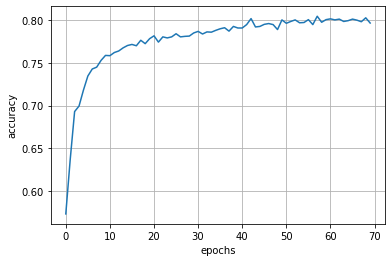

{'dropout_prob': 0.25, 'l1_param': 0.001, 'n_filters': 500, 'window_size': 3}


In [12]:
# Find the optimal config by considering the asymptotic behaviour of the accuracy curve
N_transient = 40    
optimal_config = np.argmax([np.mean(curve[N_transient:]) for curve in CV_df['accuracy_mean']])

# Optimal set of parameters
opt_labels = CV_df['params'].iloc[optimal_config]

# plot the accuracy curve
accuracy_curve = CV_df['accuracy_mean'].iloc[optimal_config]
plt.plot(accuracy_curve)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.show()

print(opt_labels)

### Training the model

Now that the optimal parameters have been selected, we should train the model and use it on the test set.

In [11]:
# The optimal parameters
n_filters = 500
window_size = 3
dropout_prob = 0.25
l1_param = 0.001
output_classes = len(labels)

# Let's create the embeddin layer using the pre-trained word2vec embedding
w2v_embedding_layer = at.get_keras_embedding(FTwv)
conv_reg = tf.keras.regularizers.L1(l1_param)

# The NN is created as a sequence of layers whose output is the input of the next one
model = tf.keras.Sequential()
model.add(w2v_embedding_layer)
model.add(tf.keras.layers.Conv1D(n_filters, window_size, activation='relu',kernel_regularizer=conv_reg))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dropout(dropout_prob))
model.add(tf.keras.layers.Dense(output_classes,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         947400    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 500)         150500    
_________________________________________________________________
global_max_pooling1d (Global (None, 500)               0         
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 9)                 4509      
Total params: 1,102,409
Trainable params: 155,009
Non-trainable params: 947,400
_________________________________________________________________


We specify which optimizer to use, the loss to minizime, and the metrics to consider,

In [12]:
lr = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Finally, we can train the model

In [13]:
n_cpu = multiprocessing.cpu_count()
eps = 70

history = model.fit(x=X_train,
                    y=y_train,
                    epochs=eps,
                    verbose=0,
                    workers=n_cpu
                   )

And visualize the training accuracy (to see when we are equilibrating),

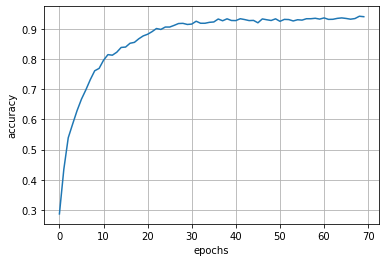

In [16]:
plt.plot(history.history['accuracy'],label='training accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.show()

### Evaluate the model

We can now evaluate the CNN trained above, by considering its performance on a test set. We consider precision, recall (and F1 score), as well as accuracy.

                            precision    recall  f1-score   support

         ad cft correspond       0.72      0.91      0.81       217
     beyond standard model       0.90      0.93      0.92        82
 dualiti gaug field theori       0.75      0.54      0.63       130
field theori higher dimens       0.68      0.65      0.66       168
 field theori lower dimens       0.62      0.56      0.59       207
               gaug theori       0.87      0.83      0.85        82
            quantum mechan       0.91      0.96      0.93        89
              state physic       0.96      1.00      0.98       323
            statist physic       0.92      0.85      0.88       104

                  accuracy                           0.81      1402
                 macro avg       0.81      0.80      0.80      1402
              weighted avg       0.80      0.81      0.80      1402



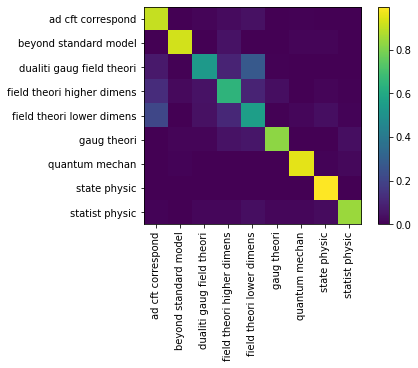

In [17]:
# Predict probability distribution
prob_predict = model.predict(X_test)

# Predict the labels
y_predict = np.argmax(prob_predict,axis=1)
y_test_label = np.argmax(y_test,axis=1)

# Let's check the performance of the classifier
performance_CNN = classification_report(y_test_label, y_predict,target_names=labels)
print(performance_CNN)

# Let's visualize the confusion matrix for this classifier
confusion_mat = confusion_matrix(y_test_label,y_predict,normalize='true')

plt.imshow(confusion_mat)
plt.xticks(ticks=range(output_classes),labels=labels,rotation=90)
plt.yticks(ticks=range(output_classes),labels=labels)
plt.colorbar()
plt.show()

Some remarks are in order, in particular if we compare to the results obtained in the other study we performed on the dataset [link](https://github.com/carlosparaciari/abstract-classification-supervised).

With the current word embedding + classification model, we see that the accuracy of the classifier exceeds the one obtained in the previous study (here accuracy is 81%, previous accuracies were in the range 73-77%).

We additionally see that the model struggles with three classes in particuar, specifically "dualiti gaug field theori", "field theori higher dimens", and "field theori lower dimens", where we judge the performance according to the F1 score, and the three classes highlighted have an F1 score < 0.7, while all the other classes have an F score > 0.8.

It is worth noting that the same occurs with every models emploied in the other study, highlighting the fact that these three classes are hinerently difficult to distinguish.

Finally, we store the model,

In [27]:
model.save('./models/cnn_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/cnn_model\assets


## 2.b RNN for abstract classification

We now consider a Recursive Neural Network, that is, a neural network architecture where the each work in the sentence is processed while haing some memory of the previous words (by using a bi-directional layer, we will in fact have information about both the previous and the following words).

The recursive layer we will use will empoly Long Short-Term Memory (LSTM) cells, that are able to store relevant information for unspecified time-steps.

The construction we use is inspired by D. Tang, et al., "Document Modeling with Gated Recurrent Neural Network for Sentiment Classification" [link](https://www.aclweb.org/anthology/D15-1167). The structure of the model is,

<img src="diagrams/RNN.png" width="400" />

- The **input/embedding layer** consists of a matrix $n \times k$ where $n$ is the number of words in the text (in this case the title+abstract) and $k$ is the dimension of the vector space where we perform the word2vec embedding (in our case, it is $k=100$). Since the LSTM layer allow for this, we mask the padding ade to make all sequences of equal length.


- The second layer is a **recursive (bidiectional) layer** made up by LSTM cells those output is $m$ dimensional. We could then decide to consider the output of all cells and average it, take the max value, or consider the last output. We go with the latter choice.


- After the recursive layer, we apply a **fully-connected layer** with rectified linear units (ReLU).


- Finally, a **fully-connected layer** with drops-out with softmax output

In [ ]:
model = tf.keras.models.load_model('./models/rnn_model')

### Hyper-parameters selection

We run K-fold cross-validation on a different machine, with the following range of parameters,

- `n_units` = $[50,100,150,200,250,300]$
- `n_hidden` = $[100,200,300,400]$
- `dropout_prob` = $[0.01,0.1,0.25,0.5]$

We additionally checked for a much higher number of units in the recurrent layer (600 units), togehter with the best choice for the other hyper-parameters (obtained via the cross-validation grid above). We did not find any significant increase in accuracy.

Let's load the database with the cross validation results,

In [27]:
CV_df = pd.read_pickle('./cross-val/rnn/cross_val_results.pkl')

And plot it,

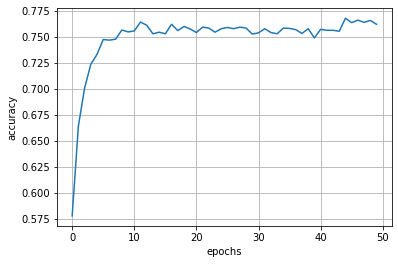

{'dropout_prob': 0.5, 'n_hidden': 200, 'n_units': 300}


In [28]:
# Find the optimal config by considering the asymptotic behaviour of the accuracy curve
N_transient = 20    
optimal_config = np.argmax([np.mean(curve[N_transient:]) for curve in CV_df['accuracy_mean']])

# Optimal set of parameters
opt_labels = CV_df['params'].iloc[optimal_config]

# plot the accuracy curve
accuracy_curve = CV_df['accuracy_mean'].iloc[optimal_config]
plt.plot(accuracy_curve)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.show()

print(opt_labels)

### Training the model

Now that the optimal parameters have been selected, we should train the model and use it on the test set.

In [30]:
# The optimal parameters
n_units = 300
dropout_prob = 0.5
n_hidden = 200
output_classes = len(labels)

# Create embedding layer (with masking)
w2v_embedding_layer = at.get_keras_embedding(FTwv,masking=True)

# The NN is created as a sequence of layers whose output is the input of the next one
model = tf.keras.Sequential()
model.add(w2v_embedding_layer)
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_units)))
model.add(tf.keras.layers.Dense(n_hidden, activation='relu'))
model.add(tf.keras.layers.Dropout(dropout_prob))
model.add(tf.keras.layers.Dense(output_classes,activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         947400    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 600)               962400    
_________________________________________________________________
dense_3 (Dense)              (None, 200)               120200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 1809      
Total params: 2,031,809
Trainable params: 1,084,409
Non-trainable params: 947,400
_________________________________________________________________


We specify which optimizer to use, the loss to minizime, and the metrics to consider,

In [31]:
lr = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Finally, we can train the model

In [ ]:
n_cpu = multiprocessing.cpu_count()
eps = 20

history = model.fit(x=X_train,
                    y=y_train,
                    epochs=eps,
                    workers=n_cpu
                   )

And visualize the training accuracy (to see when we are equilibrating),

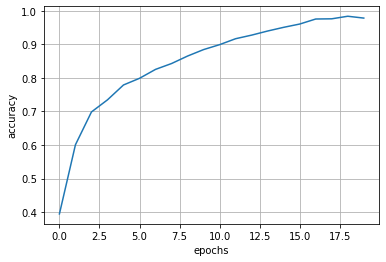

In [33]:
plt.plot(history.history['accuracy'],label='training accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.show()

### Evaluate the model

We can now evaluate the RNN trained above, by considering its performance on a test set. We consider precision, recall (and F1 score), as well as accuracy.

                            precision    recall  f1-score   support

         ad cft correspond       0.67      0.88      0.76       217
     beyond standard model       0.75      0.90      0.82        82
 dualiti gaug field theori       0.57      0.40      0.47       130
field theori higher dimens       0.63      0.50      0.56       168
 field theori lower dimens       0.58      0.47      0.52       207
               gaug theori       0.70      0.74      0.72        82
            quantum mechan       0.82      0.87      0.84        89
              state physic       0.95      0.98      0.97       323
            statist physic       0.76      0.80      0.78       104

                  accuracy                           0.74      1402
                 macro avg       0.71      0.73      0.71      1402
              weighted avg       0.73      0.74      0.73      1402



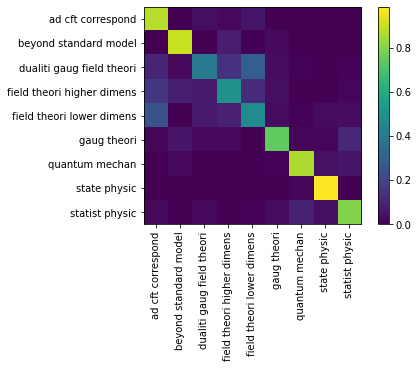

In [34]:
# Predict probability distribution
prob_predict = model.predict(X_test)

# Predict the labels
y_predict = np.argmax(prob_predict,axis=1)
y_test_label = np.argmax(y_test,axis=1)

# Let's check the performance of the classifier
performance_CNN = classification_report(y_test_label, y_predict,target_names=labels)
print(performance_CNN)

# Let's visualize the confusion matrix for this classifier
confusion_mat = confusion_matrix(y_test_label,y_predict,normalize='true')

plt.imshow(confusion_mat)
plt.xticks(ticks=range(output_classes),labels=labels,rotation=90)
plt.yticks(ticks=range(output_classes),labels=labels)
plt.colorbar()
plt.show()

Interestingly, we find that the preformance of a Recursive Neural Network is in this setting lower than that of a Convolutional Neural Network. In particular, the accuracy achieved over the test set is around 74%, falling into the lower part of the accuracy range obtained in a previous study (see the [link](https://github.com/carlosparaciari/abstract-classification-supervised)).

A more in depth analysis shows that the model struggles with the usual 3 classes, "dualiti gaug field theori", "field theori higher dimens", "field theori lower dimens" (with F1 scores below 0.6), and performs poorly on the class "gaug theori" (with a F1 score below 0.75).

Let's store the model,

In [35]:
model.save('./models/rnn_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/rnn_model\assets


## 3. Model evaluation

We'd now like to compare the accuracy of the different models, to understand which pair of model is significantly different from one another. Since the test data are the same for all the model, the test errors are correlated and one cannot use a two-sample t-test.

Instead, we will perform the [McNemar test](https://en.wikipedia.org/wiki/McNemar%27s_test); given two models M1 and M2, we build the table

| M1 \ M2     | Correct     |  Error       |
| ----------- | ----------- |  ----------- |
| Correct     | a           |  b           |
| Error       | c           |  d           |

The *null hp* is that the probability of correct and error are the same for the two models,

- $p(correct|M1) = p_a + p_b = p_a + p_c = p(correct|M1)$
- $p(error|M1) = p_c + p_d = p_b + p_d = p(error|M1)$

Equivalently, the null hp is $p_b = p_c$, and the alternative hp is that they are different (and therefore one of the model is significanlty different from the other).

The test statistics is $(b-c)^2/(b+c)$, with a Chi-square distribution with 1 dof.

In [11]:
# Load the two models
model_CNN = tf.keras.models.load_model('./models/cnn_model')
model_RNN = tf.keras.models.load_model('./models/rnn_model')

The Mc Nemar confirms that the performance of the two models are significantly different,

In [21]:
# List of all models trained in the notebook
models = [model_CNN, model_RNN]
names = ['CNN','RNN']

# Comparison via McNemar test
at.models_comparison(models,names,X_test,y_test_label)

Null hypothesis (the two tests are equivalent) is rejected for p_val < 0.050
---
M1 = RNN vs M2 = CNN

+---------+------+-----+---------+
|  M1\M2  |  C2  |  E2 | sum row |
+---------+------+-----+---------+
|    C1   | 968  |  69 |   1037  |
|    E1   | 163  | 202 |   365   |
| sum col | 1131 | 271 |   1402  |
+---------+------+-----+---------+

Null hypothesis rejected - models are significantly different (p_val= 0.000)
